In [1]:
from __future__ import print_function                                            

import psycopg2                                                                  
import getpass                                                                   
import numpy as np                                                               
import pandas as pd                                                              
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import palettable
import cycler

from sklearn.linear_model import LinearRegression

from train_model import MODEL_FEATURES
from utils import features_key, load, save

pd.options.display.max_columns = 100

sns.set(style="white", font_scale=1.3)
mpl.rcParams.update({'font.size': 22})
bmap = palettable.colorbrewer.get_map ('Set1', 'qualitative', '7')
mpl.rcParams['axes.prop_cycle'] = cycler.cycler ('color', bmap.mpl_colors)

%matplotlib notebook

In [2]:
dbname = 'stroke_prev'

username = raw_input ('postgresql username: ')
password = getpass.getpass ('password: ')

con = psycopg2.connect(database=dbname, 
                       user=username, 
                       password=password,
                       host='/var/run/postgresql')

postgresql username: rmaunu
password: ········


In [3]:
sql_query = """
SELECT * FROM analysis_database_stroke
"""
stroke_data = pd.read_sql_query(sql_query, con)
stroke_data = stroke_data.rename (columns={'Value': 'stroke_death'})

stroke_data.where (stroke_data != -1, other=np.nan, inplace=True)

In [4]:
model_reg = load ('ml_r2/linear_model.pickle')
model_lasso = load ('ml_r2/linear_lasso_model.pickle')
model_ridge = load ('ml_r2/linear_ridge_model.pickle')
model_elasticnet = load ('ml_r2/elasticnet_model.pickle')
model_svr = load ('ml_r2/svr_model.pickle')
model_random_forest = load ('ml_r2/random_forest_model.pickle')
model_xgboost_forest = load ('ml_r2/xgboost_forest_model.pickle')

model_features_imp = load ('ml_r2/model_features_imp.pickle')
model_features_final = load ('ml_r2/model_features_final.pickle')

med_imputer = load ('ml_r2/med_imputer.pickle')
std_scaler = load ('ml_r2/std_scale.pickle')

X_train = load ('ml_r2/X_train.pickle')
X_test = load ('ml_r2/X_test.pickle')
y_train = load ('ml_r2/y_train.pickle')
y_test = load ('ml_r2/y_test.pickle')

target_key = 'stroke_hosp'

y_all_data = stroke_data[target_key]

X_all = stroke_data[model_features_imp]
X_all_imp = med_imputer.transform (X_all)
X_all_imp = pd.DataFrame (X_all_imp, columns=X_all.columns, 
                          index=X_all.index)
X_all_final = std_scaler.transform (X_all_imp)
X_all_final = pd.DataFrame (X_all_final, columns=X_all.columns, 
                            index=X_all.index)
X_all_final = X_all_final[model_features_final]

key_dict = {}
for i, col in enumerate (X_train.columns):
    key_dict[i+1] = col

<IPython.core.display.Javascript object>


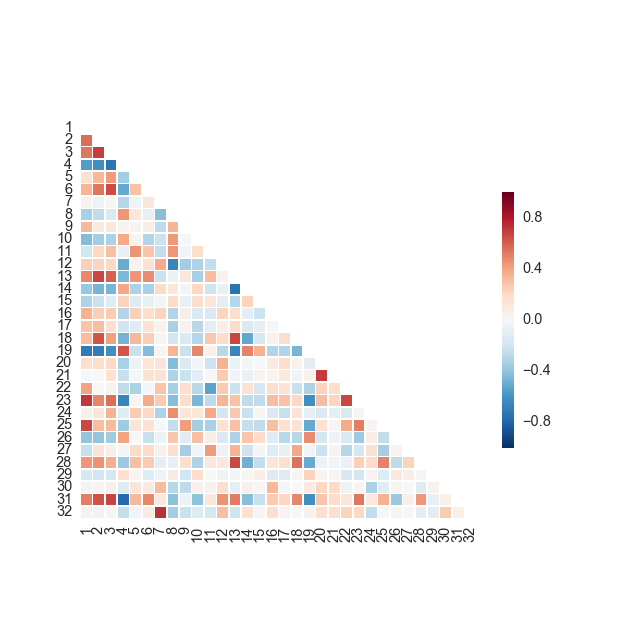

In [5]:
corr = X_train.corr ()
mask = np.zeros_like(corr, dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

fig = plt.figure (figsize=(8, 8))
ax = fig.add_subplot (111)
sns.heatmap(corr,  mask=mask,  vmax=1,  square=True, 
            linewidths=.5,  cbar_kws={"shrink": .5}, ax=ax, 
            xticklabels=range (1, len (X_train.columns)+1), 
            yticklabels=range (1, len (X_train.columns)+1)
            )
plt.xticks(rotation=90) 
plt.yticks(rotation=0) 
fig.savefig ('plots/corr_heatmap_final.png', bbox_inches='tight',
             transparent=False)

In [6]:
for key in key_dict.keys ():
    print ('{0:d}:'.format (key), features_key[key_dict[key]])

1: Physical Inactivity Percentage (%)
2: No HS Diploma (%)
3: SNAP Recipients (%)
4: Median Household Income ($1000s)
5: GINI Coefficient (Income Inequality)
6: Unemployment Rate (%)
7: 65yr or older (%)
8: Total Population
9: Air Quality PM2.5
10: Percentage of Population Living Within Half a Mile of a Park
11: Percentage of Households Living with Severe Housing Problems, 2008-2012
12: Urban-Rural Status
13: Blood-Pressure Medication Nonadherence (%)
14: Fraction of BLMN, Diuretic
15: Fraction of BLMN, Renin-Angiotensin System Antagonist
16: Pharmacies and Drug-Stores (per 100,000)
17: Population per Primary-Care Physician
18: Percentage without Health Insurance, Under Age 65
19: Prevalence of Any Drinking (%)
20: Fraction of drinking, binge (2011)
21: Fraction of drinking, heavy (2011)
22: Fraction of smokers, daily (2011)
23: Total Smoking Prevalence (%)
24: SNAP redemptions per SNAP-authorized stores (2012)
25: Obese Adult Prevalence (%, 2013)
26: Recreation & fitness facilities (p

In [9]:
cv_reg = {'mean': 0.428427608669,
          'std': 0.0396375003687}
selector_ridge = load ('ml_r2/grid_search_linear_ridge_model.pickle')
selector_lasso = load ('ml_r2/grid_search_linear_lasso_model.pickle')
selector_elasticnet = load ('ml_r2/grid_search_elasticnet_model.pickle')
selector_svr = load ('ml_r2/grid_search_svr_model.pickle')
selector_random_forest = load ('ml_r2/grid_search_random_forest_model.pickle')
selector_xgboost_forest = load ('ml_r2/grid_search_xgboost_forest_model.pickle')

In [10]:
models = ['Linear Regression',
          'Ridge Regression',
          'LASSO',
          'ElasticNet',
          'SVR',
          'Random Forest',
          'XGBoost'
         ]

cv_means = [cv_reg['mean']]
cv_stds = [cv_reg['std']]

for selector in (selector_ridge, selector_lasso, selector_elasticnet,
                 selector_svr, selector_random_forest, selector_xgboost_forest):
    mean_tmp = selector.best_score_
    for grid_point in selector.grid_scores_:
        if grid_point.parameters == selector.best_params_:
            cv_means.append (grid_point.mean_validation_score)
            cv_stds.append (grid_point.cv_validation_scores.std ())
            break
        

<IPython.core.display.Javascript object>


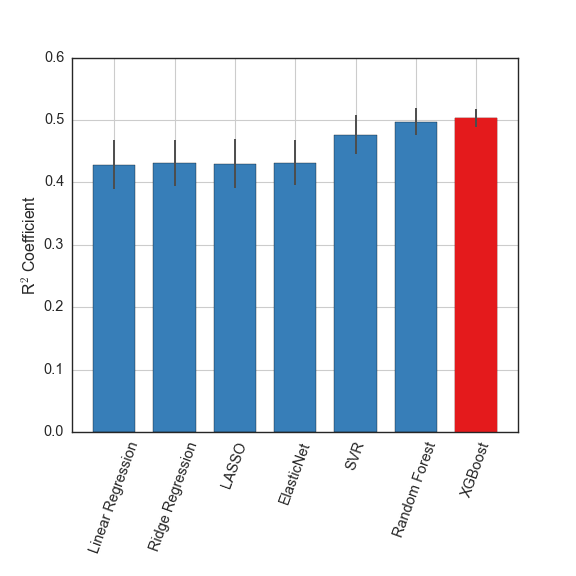

In [11]:
aspect = (4./ 3.)**-1
width = 8.
scale = 0.8

error_config = {'ecolor': '0.3'}
bar_width = 0.7
scale = 0.9

fig = plt.figure (figsize=(scale*width, scale*width))
ax = fig.add_subplot (111)
fig.subplots_adjust (bottom=0.25)

ind = np.arange (len (models))
cv_means = np.array (cv_means)
cv_stds = np.array (cv_stds)

ax.bar (ind, cv_means, bar_width,
        yerr=cv_stds, color=bmap.mpl_colors[1],
        error_kw=error_config)
ax.bar (ind[-1], cv_means[-1], bar_width,
        yerr=cv_stds[-1], color=bmap.mpl_colors[0], edgecolor=bmap.mpl_colors[0],
        error_kw=error_config)

ax.set_xticks(ind + bar_width / 2)
ax.set_xticklabels (models)
ax.set_xlim (ind.min () - bar_width / 2., ind.max () + 3 * bar_width / 2.)
ax.set_ylabel (r'R$^2$ Coefficient')
ax.grid ()
plt.xticks(rotation=70)

fig.savefig ('plots/model_selection_cv.png', bbox_inches='tight',
             transparent=False)

<IPython.core.display.Javascript object>


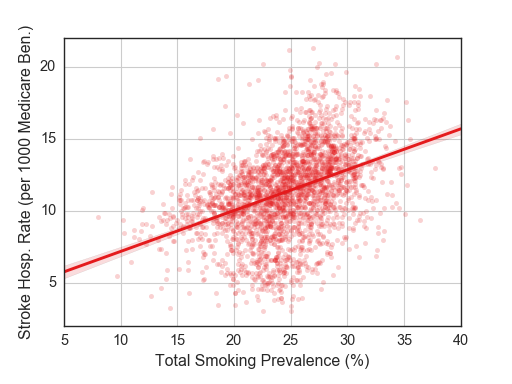

In [15]:
aspect = (4./ 3.)**-1
width = 8.
scale = 0.8

fig = plt.figure (figsize=(scale*width, scale*width*aspect))
ax = fig.add_subplot (111)
fig.subplots_adjust (bottom=0.15)

sns.regplot (x=X_all['total_mean_smoking_2011'], y=y_all_data, scatter_kws=dict (alpha=0.2), ax=ax, ci=95)
ax.set_xlabel (features_key['total_mean_smoking_2011'])
ax.set_ylabel (features_key['stroke_hosp'])
ax.grid ()
ax.set_xlim (5, 40)
ax.set_ylim (2, 22)

fig.savefig ('plots/stroke_total_mean_smoking_2011.png', transparent=False)

<IPython.core.display.Javascript object>


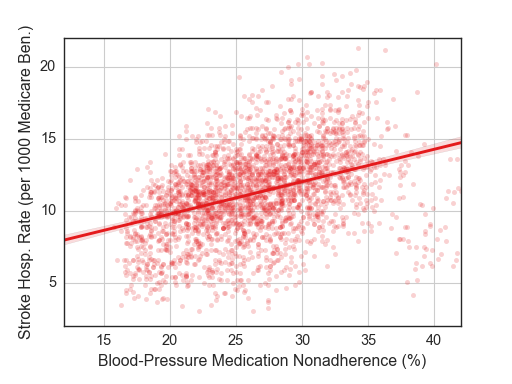

In [16]:
fig = plt.figure (figsize=(scale*width, scale*width*aspect))
ax = fig.add_subplot (111)
fig.subplots_adjust (bottom=0.15)

sns.regplot (x=X_all['htnadh_all'], y=y_all_data, 
             fit_reg=True,
             scatter_kws=dict (alpha=0.2), ax=ax, ci=95)
ax.set_xlabel (features_key['htnadh_all'])
ax.set_ylabel (features_key['stroke_hosp'])
ax.grid ()
ax.set_xlim (12, 42)
ax.set_ylim (2, 22)

fig.savefig ('plots/stroke_htnadh_all.png', transparent=False)  

<IPython.core.display.Javascript object>


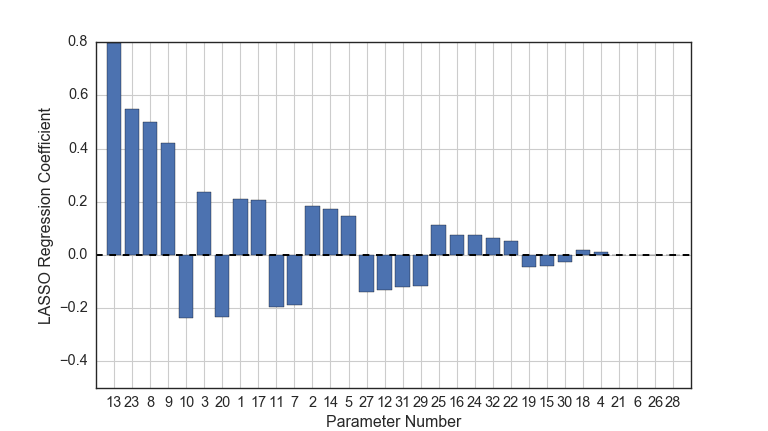

In [22]:
scale=1.2
aspect=(16/9.)**-1

fig = plt.figure (figsize=(scale*width, scale*width*aspect))
ax = fig.add_subplot (111)
sort_idx = np.abs (model_lasso.coef_).argsort ()[::-1]
ind = np.arange (1, len (X_train.columns)+1)
ax.bar (ind, model_lasso.coef_[sort_idx], align='center')
ax.axhline (0, color='k', ls='--')
ax.grid ()
ax.set_xticks(ind)
ax.set_xticklabels (ind[sort_idx])
ax.set_xlim (0., 33.)
ax.set_ylim (-0.5, 0.8)
ax.set_xlabel ('Parameter Number')
ax.set_ylabel ('LASSO Regression Coefficient')

fig.savefig ('plots/var_coef_lasso_model.png', bbox_inches='tight', transparent=False)

<IPython.core.display.Javascript object>


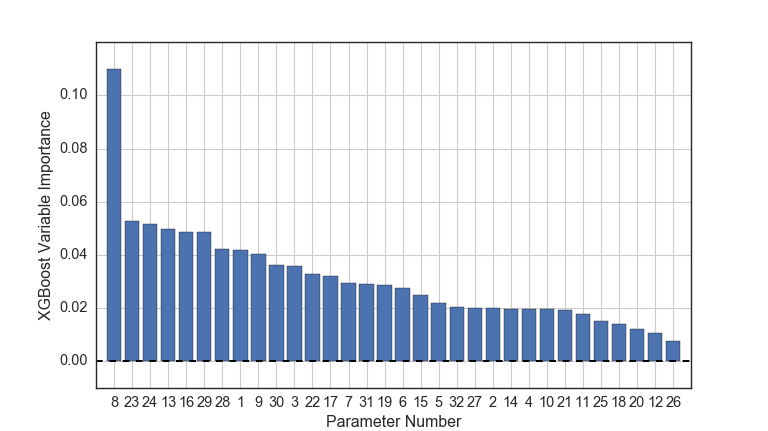

In [27]:
scale=1.2
xgb_imp = model_xgboost_forest.booster().get_score (importance_type='weight')

total_splits = 0
xgb_idx = []
for key in xgb_imp.keys ():
    total_splits += xgb_imp[key]
    for k, val in key_dict.iteritems ():
        if key == val:
            xgb_idx.append (k)
            break
            
xgb_vals = []
for key in xgb_imp.keys ():
    xgb_vals.append (float (xgb_imp[key]) / total_splits)
            
xgb_idx = np.array (xgb_idx)
xgb_vals = np.array (xgb_vals)


fig = plt.figure (figsize=(scale*width, scale*width*aspect))
ax = fig.add_subplot (111)
sort_idx = xgb_vals.argsort ()[::-1]
labels = []
for i in sort_idx:
    labels.append (xgb_idx[i])
ind = np.arange (1, len (X_train.columns)+1)
ax.bar (ind, xgb_vals[sort_idx], align='center')
ax.axhline (0, color='k', ls='--')
ax.grid ()
ax.set_xticks(ind)
ax.set_xticklabels (labels)
ax.set_xlim (0., 33.)
ax.set_ylim (-0.01, 0.12)
ax.set_xlabel ('Parameter Number')
ax.set_ylabel ('XGBoost Variable Importance')

fig.savefig ('plots/var_imp_xgboost_forest_model.png', bbox_inches='tight', transparent=False)

<IPython.core.display.Javascript object>


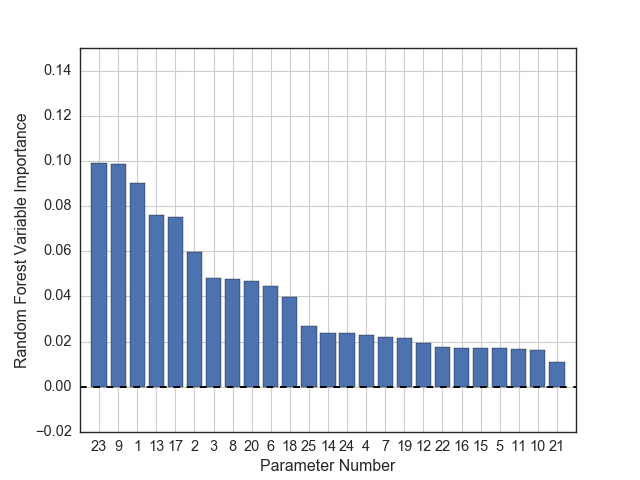

In [15]:
scale=1.

fig = plt.figure (figsize=(scale*width, scale*width*aspect))
ax = fig.add_subplot (111)
sort_idx = model_random_forest.feature_importances_.argsort ()[::-1]
ind = np.arange (1, len (X_train.columns)+1)
ax.bar (ind, model_random_forest.feature_importances_[sort_idx], align='center')
ax.axhline (0, color='k', ls='--')
ax.grid ()
ax.set_xticks(ind)
ax.set_xticklabels (ind[sort_idx])
ax.set_xlim (0., 26.)
ax.set_ylim (-0.02, 0.15)
ax.set_xlabel ('Parameter Number')
ax.set_ylabel ('Random Forest Variable Importance')

fig.savefig ('plots/var_coef_random_forest_model.png', bbox_inches='tight', transparent=False)

<IPython.core.display.Javascript object>


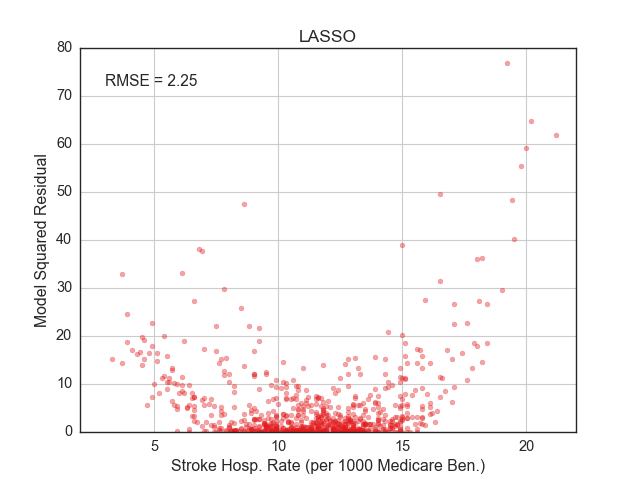

In [16]:
y_pred = model_lasso.predict (X_test)
res = y_pred - y_test

fig = plt.figure (figsize=(scale*width, scale*width*aspect))
ax = fig.add_subplot (111)
ax.scatter (y_test, res**2, color=bmap.mpl_colors[0], alpha=0.4)
ax.grid ()
ax.set_xlim (2, 22)
ax.set_ylim (0, 80)
ax.set_xlabel (features_key[target_key])
ax.set_ylabel ('Model Squared Residual')
ax.set_title ('LASSO')
ax.text (3, 72, 'RMSE = {0:.2f}'.format (np.sqrt ((res**2).sum () / len (res))),
         fontdict=dict(size=14))

fig.savefig ('plots/sq_res_lasso_model_test.png')

<IPython.core.display.Javascript object>


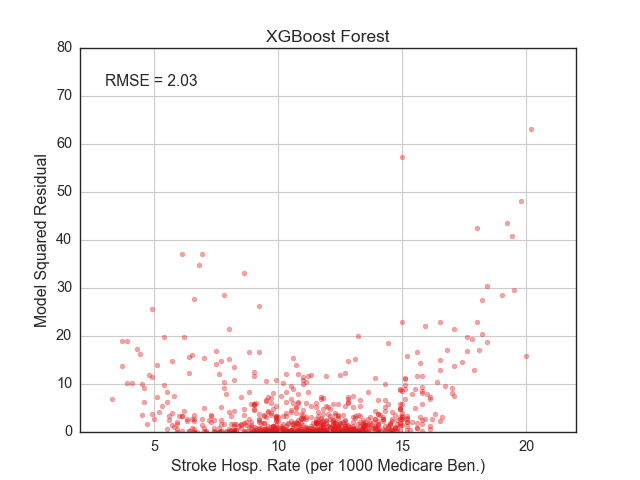

In [17]:
y_pred = model_xgboost_forest.predict (X_test)
res = y_pred - y_test

fig = plt.figure (figsize=(scale*width, scale*width*aspect))
ax = fig.add_subplot (111)
ax.scatter (y_test, res**2, color=bmap.mpl_colors[0], alpha=0.4)
ax.grid ()
ax.set_xlim (2, 22)
ax.set_ylim (0, 80)
ax.set_xlabel (features_key[target_key])
ax.set_ylabel ('Model Squared Residual')
ax.set_title ('XGBoost Forest')
ax.text (3, 72, 'RMSE = {0:.2f}'.format (np.sqrt ((res**2).sum () / len (res))),
         fontdict=dict(size=14))

fig.savefig ('plots/sq_res_xgboost_forest_model_test.png')

<IPython.core.display.Javascript object>


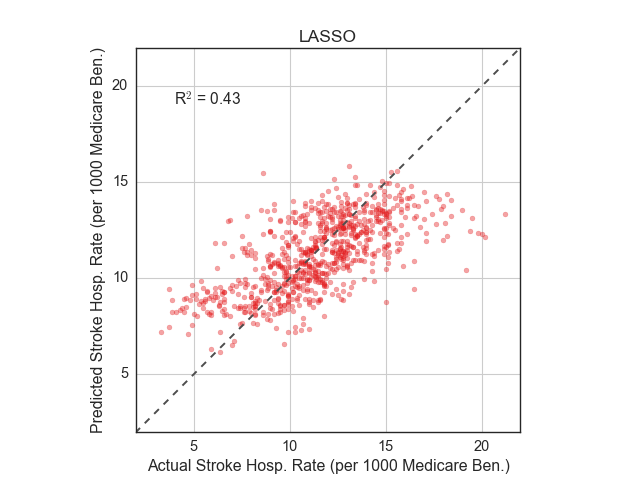

In [18]:
y_pred = model_lasso.predict (X_test)

fig = plt.figure (figsize=(scale*width, scale*width*aspect))
ax = fig.add_subplot (111)
ax.scatter (y_test, y_pred, color=bmap.mpl_colors[0], alpha=0.4)
ax.plot (np.linspace (0, 100, 2), np.linspace (0, 100, 2), ls='--', color='0.3')
ax.grid ()
ax.set_aspect ('equal')
ax.set_xlim (2, 22)
ax.set_ylim (2, 22)
ax.set_xlabel ('Actual ' + features_key[target_key])
ax.set_ylabel ('Predicted ' + features_key[target_key])
ax.set_title ('LASSO')
ax.text (4, 19, r'R$^2$ = {0:.2f}'.format (model_lasso.score (X_test, y_test)),
         fontdict=dict(size=14))

fig.savefig ('plots/r2_lasso_model_test.png', bbox_inches='tight', transparent=False)

<IPython.core.display.Javascript object>


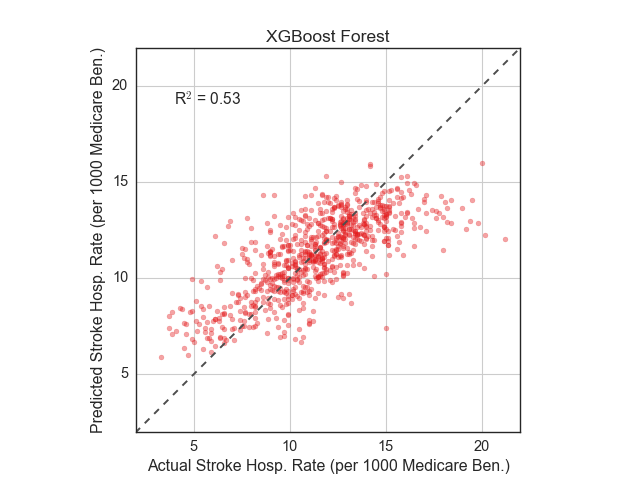

In [19]:
y_pred = model_xgboost_forest.predict (X_test)

fig = plt.figure (figsize=(scale*width, scale*width*aspect))
ax = fig.add_subplot (111)
ax.scatter (y_test, y_pred, color=bmap.mpl_colors[0], alpha=0.4)
ax.plot (np.linspace (0, 100, 2), np.linspace (0, 100, 2), ls='--', color='0.3')
ax.grid ()
ax.set_aspect ('equal')
ax.set_xlim (2, 22)
ax.set_ylim (2, 22)
ax.set_xlabel ('Actual ' + features_key[target_key])
ax.set_ylabel ('Predicted ' + features_key[target_key])
ax.set_title ('XGBoost Forest')
ax.text (4, 19, r'R$^2$ = {0:.2f}'.format (model_xgboost_forest.score (X_test, y_test)),
         fontdict=dict(size=14))

fig.savefig ('plots/r2_xgboost_forest_model_test.png', bbox_inches='tight', transparent=False)

<IPython.core.display.Javascript object>


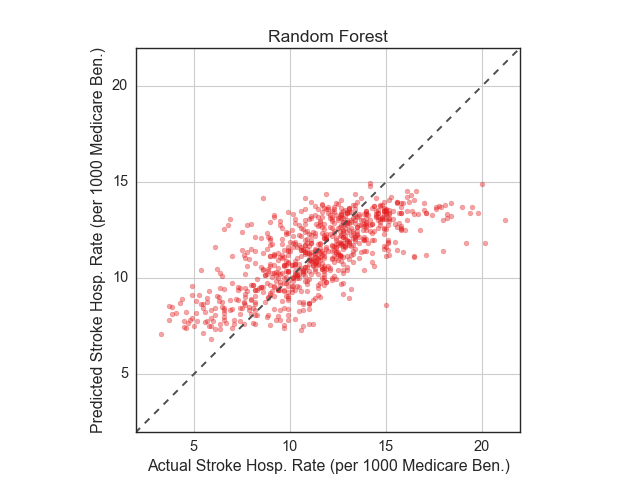

In [20]:
y_pred = model_random_forest.predict (X_test)

fig = plt.figure (figsize=(scale*width, scale*width*aspect))
ax = fig.add_subplot (111)
ax.scatter (y_test, y_pred, color=bmap.mpl_colors[0], alpha=0.4)
ax.plot (np.linspace (0, 100, 2), np.linspace (0, 100, 2), ls='--', color='0.3')
ax.grid ()
ax.set_aspect ('equal')
ax.set_xlim (2, 22)
ax.set_ylim (2, 22)
ax.set_xlabel ('Actual ' + features_key[target_key])
ax.set_ylabel ('Predicted ' + features_key[target_key])
ax.set_title ('Random Forest')

fig.savefig ('plots/r2_random_forest_model_test.png', bbox_inches='tight', transparent=False)

<IPython.core.display.Javascript object>


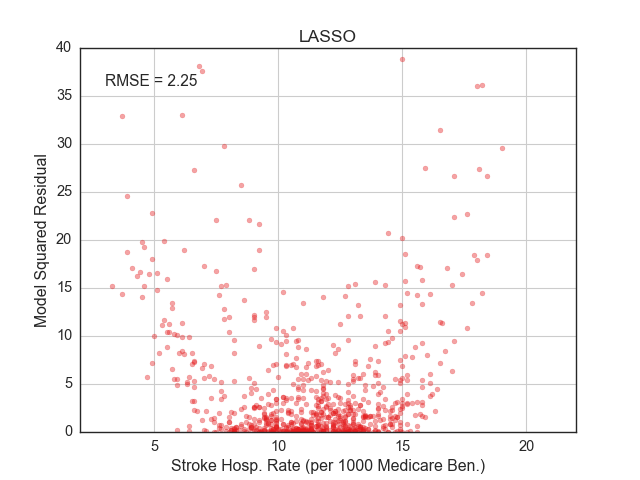

In [21]:
y_pred = model_lasso.predict (X_test)
res = y_pred - y_test

fig = plt.figure (figsize=(scale*width, scale*width*aspect))
ax = fig.add_subplot (111)
ax.scatter (y_test, res**2, color=bmap.mpl_colors[0], alpha=0.4)
ax.grid ()
ax.set_xlim (2, 22)
ax.set_ylim (0, 40)
ax.set_xlabel (features_key[target_key])
ax.set_ylabel ('Model Squared Residual')
ax.set_title ('LASSO')
ax.text (3, 36, 'RMSE = {0:.2f}'.format (np.sqrt ((res**2).sum () / len (res))),
         fontdict=dict(size=14))

fig.savefig ('plots/sq_res_zoom_lasso_model_test.png')

<IPython.core.display.Javascript object>


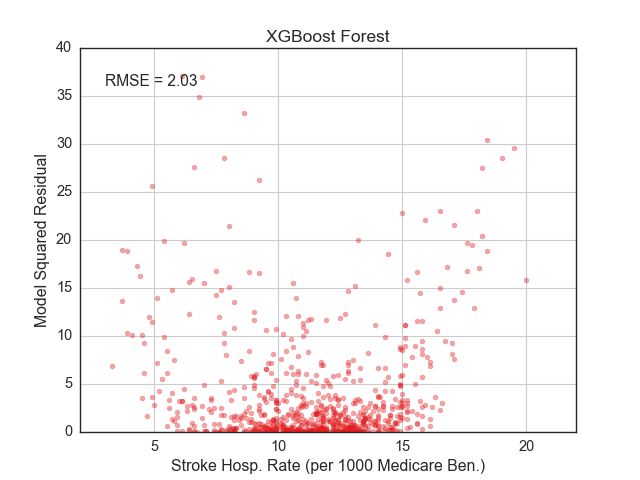

In [22]:
y_pred = model_xgboost_forest.predict (X_test)
res = y_pred - y_test

fig = plt.figure (figsize=(scale*width, scale*width*aspect))
ax = fig.add_subplot (111)
ax.scatter (y_test, res**2, color=bmap.mpl_colors[0], alpha=0.4)
ax.grid ()
ax.set_xlim (2, 22)
ax.set_ylim (0, 40)
ax.set_xlabel (features_key[target_key])
ax.set_ylabel ('Model Squared Residual')
ax.set_title ('XGBoost Forest')
ax.text (3, 36, 'RMSE = {0:.2f}'.format (np.sqrt ((res**2).sum () / len (res))),
         fontdict=dict(size=14))

fig.savefig ('plots/sq_res_zoom_xgboost_forest_model_test.png')

<IPython.core.display.Javascript object>


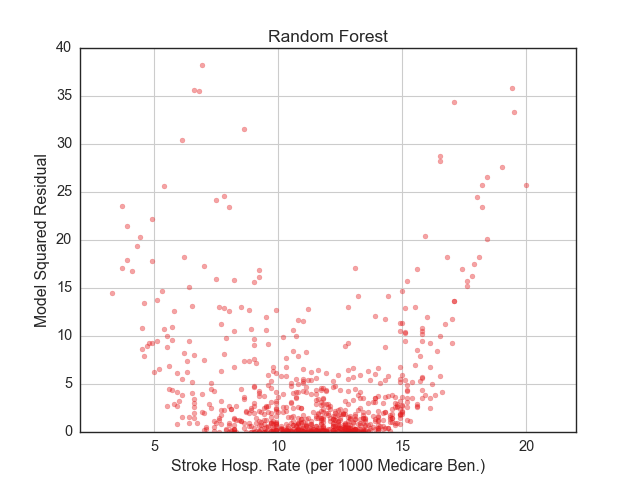

In [23]:
y_pred = model_random_forest.predict (X_test)
res = y_pred - y_test

fig = plt.figure (figsize=(scale*width, scale*width*aspect))
ax = fig.add_subplot (111)
ax.scatter (y_test, res**2, color=bmap.mpl_colors[0], alpha=0.4)
ax.grid ()
ax.set_xlim (2, 22)
ax.set_ylim (0, 40)
ax.set_xlabel (features_key[target_key])
ax.set_ylabel ('Model Squared Residual')
ax.set_title ('Random Forest')

fig.savefig ('plots/sq_res_zoom_random_forest_model_test.png')